In [62]:
import numpy as np
import pandas as pd
from Bio import Phylo
import random

def get_dist_matrix_from_tree(tree_file):
    """
    Performs phylogenetic block k-fold cross-validation.

    Args:
        tree_file (str): Path to the phylogenetic tree file (Newick format).
        fold_list (list): List of the number of folds to test.

    Returns:
        list: List of dictionaries, each containing fold assignments and distance metrics.
    """

    # Load phylogenetic tree
    tree = Phylo.read(tree_file, "newick")
    # Get tip names
    tip_names = [terminal.name for terminal in tree.get_terminals()]
    #dist_matrix = tree.distance_matrix().values

    #Create distance matrix from the tree
    dist_matrix = np.zeros((len(tree.get_terminals()), len(tree.get_terminals())))
    for i, terminal1 in enumerate(tree.get_terminals()):
        for j, terminal2 in enumerate(tree.get_terminals()):
            if i < j:  # Only calculate upper triangle to avoid redundancy
                dist_matrix[i, j] = tree.distance(terminal1, terminal2)
                dist_matrix[j, i] = dist_matrix[i, j]  # Mirror for symmetry
    
    #tips_for_tr = []
    #for names in tip_names:
    #    tips_for_tr.append(f'd_{names}')
    #print(tips_for_tr)
    dist_df =  pd.DataFrame(dist_matrix, index=tip_names, columns=tip_names)

            
    return dist_df, dist_matrix, tip_names


In [2]:
tree_file = "./opsin_wt_tree/vpod_1.1_wt/wt_aligned_VPOD_1.1_het.fasta.treefile"
dist_df, dist_matrix, tip_names = get_dist_matrix_from_tree(tree_file)

In [3]:
def farthest_points(distance_matrix, k=10):
    n = distance_matrix.shape[0]

    # Calculate average distances (initially to all points)
    
    avg_distances = np.mean(distance_matrix, axis=1)
    avg_distances_hold = np.mean(distance_matrix, axis=1)
    print(f'These are the average distances for each leaf:\n{avg_distances}')
    
    # Initialize cluster (here, we start with the point with max avg distance)
    point_list = [np.argmax(avg_distances)]
    avg_distances = np.delete(avg_distances, np.argmax(avg_distances))

    while len(point_list) < k:
        # Find the point with the highest average distance to existing cluster members
        max_avg_dist = -1
        best_point = -1
        for i in range(n):
            if i in point_list:
                continue
            avg_dist_to_cluster = np.mean(distance_matrix[i, point_list])
            if avg_dist_to_cluster > max_avg_dist:
                max_avg_dist = avg_dist_to_cluster
                best_point = i
        
        # Add the best point to the cluster
        point_list.append(best_point)
        avg_distances = np.delete(avg_distances, best_point)

    print(f'Length of avg. distances after intial point assignment is:{len(avg_distances)}')

    return point_list, avg_distances, avg_distances_hold

In [84]:
def phylo_weighted_cv(distance_matrix, tip_names, n_initial_bins, distance_threshold, relation_mode='leave_out'):
    
    """
    Clusters terminal leaves of a phylogenetic tree into bins based on distance,
    prioritizing phylogenetic relationships.

    Args:
        distance_matrix: A square numpy array representing pairwise distances.
        n_initial_bins: The number of initial bins to create with the most distant points.
        distance_threshold: The minimum allowable distance for bin assignment.
        relation_mode: The method used to deal with nodes which fall beneath the distance threshold

    Returns:
        A dataframe of fold assignments (bin numbers) and mean 'one-to-all' distances for each terminal node of a phylogenetic tree.
    """

    n_leaves = distance_matrix.shape[0]
    class_assignments = np.full(n_leaves, -1, dtype=int)  # Initialize as -1 (unassigned)

    # 1. Initialize Bins with Most Distant Points:
    initial_points, avg_distances, avg_distances_hold = farthest_points(distance_matrix=distance_matrix , k=n_initial_bins)
    print(f'These are the intial points: {initial_points}')
    print(f'This is the length of the intial points: {len(initial_points)}')

    for i, idx in enumerate(initial_points):
        class_assignments[idx] = i

    # 2. Iteratively Add Points to Bins:
    unassigned_leaves = np.where(class_assignments == -1)[0]

    # Zip the values and labels together
    zipped_pairs = zip(avg_distances, unassigned_leaves)

    # Sort the zipped pairs in descending order based on the values
    sorted_pairs = sorted(zipped_pairs, reverse=True)  

    # Unzip the sorted pairs back into separate lists
    sorted_avg_distances, unassigned_leaves = zip(*sorted_pairs)
    
    print(f'These are the unassigned leaves: {unassigned_leaves}')
    print(f'This is the length of unassigned leaves: {len(unassigned_leaves)}')

    for leaf_idx in unassigned_leaves:
        mean_distances = [np.mean(distance_matrix[leaf_idx, class_assignments == bin_num])
                          for bin_num in range(n_initial_bins)]
        print(f'Just checking that these are distance: {mean_distances}')
        # Find best bin (highest mean distance above threshold)
        best_bin = np.argmax(mean_distances)
        if mean_distances[best_bin] >= distance_threshold:
            # Check individual distances within the best bin
            if all(distance_matrix[leaf_idx, class_assignments == best_bin] >= distance_threshold):
                class_assignments[leaf_idx] = best_bin
            else:
                # Try next best bin until a suitable bin is found or none exist
                sorted_bins = np.argsort(mean_distances)[::-1]  # Descending order
                print(f'This is the sorted bins by mean distance: {sorted_bins}')
                for bin_idx in sorted_bins[1:]:  # Skip the already checked best bin
                    if all(distance_matrix[leaf_idx, class_assignments == bin_idx] >= distance_threshold):
                        class_assignments[leaf_idx] = bin_idx
                        break
        if class_assignments[leaf_idx] == -1:
            if relation_mode == 'random':
                best_bin = random.choice(sorted_bins)
                class_assignments[leaf_idx] = best_bin
                print(f'The bin chosen using the random method is {best_bin}')            
            elif relation_mode == 'merge':
                #best_bin = np.argmin(mean_distances)
                min_distances = [min(distance_matrix[leaf_idx, class_assignments == bin_num])
                          for bin_num in range(n_initial_bins)]
                min_dist = min(min_distances)
                best_bin = min_distances.index(min_dist)  
                print(f'The best bin using the merge method is {best_bin}')            
                class_assignments[leaf_idx] = best_bin
            elif relation_mode == 'max_mean':
                class_assignments[leaf_idx] = best_bin
            else:
                #if relation_mode is set to 'leave_out' we simply keep the fold assignment as -1 
                pass


    #tip_to_fold = {tip_name: {'Fold' : assignment, 'Mean_Distance' : dist} for tip_name, assignment, dist in zip(tip_names, class_assignments, avg_distances_hold)}
    tip_to_fold_dict = {'Tip_Names' : tip_names , 'Fold' : class_assignments, 'Mean_Distance' : avg_distances_hold}
    tip_to_fold_df = pd.DataFrame(tip_to_fold_dict)
    tip_to_fold_df = tip_to_fold_df.set_index('Tip_Names')
    #tip_to_dist = dict(zip(tip_names, ))
    return tip_to_fold_df


In [65]:
def percentile_threshold(distance_matrix, percentile=5):
    """Calculates a distance threshold based on a given percentile of pairwise distances."""
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]  # Extract upper triangle
    return np.percentile(distances, percentile)


In [66]:
percentile_dist_threshold = percentile_threshold(dist_matrix)
percentile_dist_threshold

0.2500477849

In [170]:
n_initial_bins = 10 
tip_to_fold = phylo_weighted_cv(distance_matrix=dist_matrix, tip_names=tip_names, n_initial_bins=n_initial_bins, distance_threshold=percentile_dist_threshold, relation_mode='leave_out')

These are the average distances for each leaf:
[1.47838048 1.59276812 1.58001156 1.57565462 1.62380009 1.63366234
 1.62723773 1.565617   1.55847353 1.58156603 1.57194762 1.58922583
 1.55992539 1.55992558 1.57061779 1.56866668 1.55834862 1.57725233
 1.57725233 1.59037955 1.5776822  1.57446367 1.57745632 1.56422639
 1.54595232 1.55693051 1.59547863 1.60509471 1.56049055 1.55680686
 1.58477509 1.59443288 1.56219827 1.57115708 1.5785258  1.602344
 1.55977965 1.56374607 1.60230242 1.60575317 1.54388694 1.53716553
 1.55122954 1.54375086 1.54288659 1.52850831 1.54282693 1.54010289
 1.55863468 1.6204478  1.73701198 1.68944186 1.75145783 1.64089486
 1.74060322 1.68622603 1.75951281 1.7390181  1.5179832  1.60036838
 1.60036825 1.56770483 1.55446631 1.52350464 1.56758132 2.28959125
 2.20143836 2.26278001 2.27610192 2.17696327 1.50760985 1.55425617
 1.53933838 1.50410624 1.40190728 1.42689486 1.50975683 1.44584702
 1.5174925  1.65218625 1.37990045 1.35802569 1.46600022 1.63042629
 1.60575022 2.174

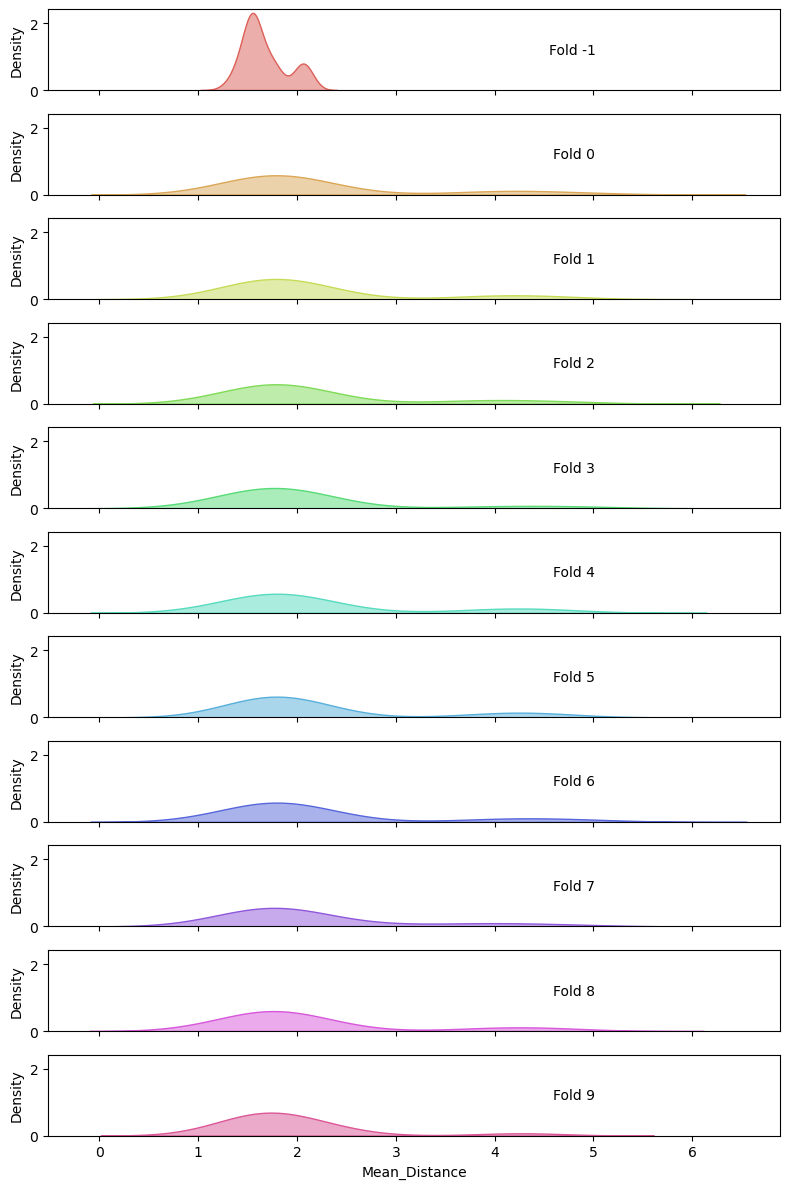

In [171]:
# Determine the number of unique labels for subplot layout
num_labels = tip_to_fold['Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
#fig.suptitle('Density Plot of Distances by Label')  # Overall figure title

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tip_to_fold['Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tip_to_fold['Mean_Distance'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tip_to_fold[tip_to_fold['Fold'] == label]['Mean_Distance']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

In [172]:
unique_classes, class_counts = np.unique(tip_to_fold['Fold'].tolist(), return_counts=True)
print(class_counts)

[89 33 30 27 16 27 48 34 20 25 13]


In [173]:
indices = tip_to_fold.index  # Get indices from the DataFrame

In [174]:
from sklearn.model_selection import KFold

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a new column for fold assignments
tip_to_fold['K-Fold'] = -1  # Initialize with -1 (unassigned)

# Assign fold labels
for fold_num, (train_indices, test_indices) in enumerate(kf.split(indices)):
    print(f'These are the test indices for fold {fold_num}:\n{test_indices}')
    tip_to_fold['K-Fold'][test_indices.tolist()] = fold_num


These are the test indices for fold 0:
[  9  15  25  33  39  42  55  57  63  72  76 101 108 114 119 126 137 148
 153 163 168 182 192 194 199 218 224 232 255 258 267 285 322 326 336 349
 358]
These are the test indices for fold 1:
[  3   5  22  30  45  46  56  73  77  78  82  90  93  94 109 124 158 173
 175 209 211 222 233 240 254 272 280 284 291 297 298 303 334 335 341 345
 346]
These are the test indices for fold 2:
[  7  16  17  24  60  66  75  84 110 113 116 132 139 140 147 157 177 195
 196 210 220 227 268 290 295 302 310 316 317 320 337 339 350 353 356 357]
These are the test indices for fold 3:
[  6  10  18  19  31  36  59  79  81 103 104 111 118 145 152 155 165 167
 172 180 181 185 219 231 244 245 247 262 265 266 277 282 286 287 301 324]
These are the test indices for fold 4:
[ 11  23  37  38  67  68  69  86  92  96  97 122 125 129 143 144 146 176
 183 197 198 203 223 229 237 256 274 275 288 304 305 314 318 325 328 344]
These are the test indices for fold 5:
[  2  29  74  83 107 

In [175]:
kfold_list = tip_to_fold['K-Fold'].tolist()

In [176]:
unique_classes, class_counts = np.unique(kfold_list, return_counts=True)
print(class_counts)

[37 37 36 36 36 36 36 36 36 36]


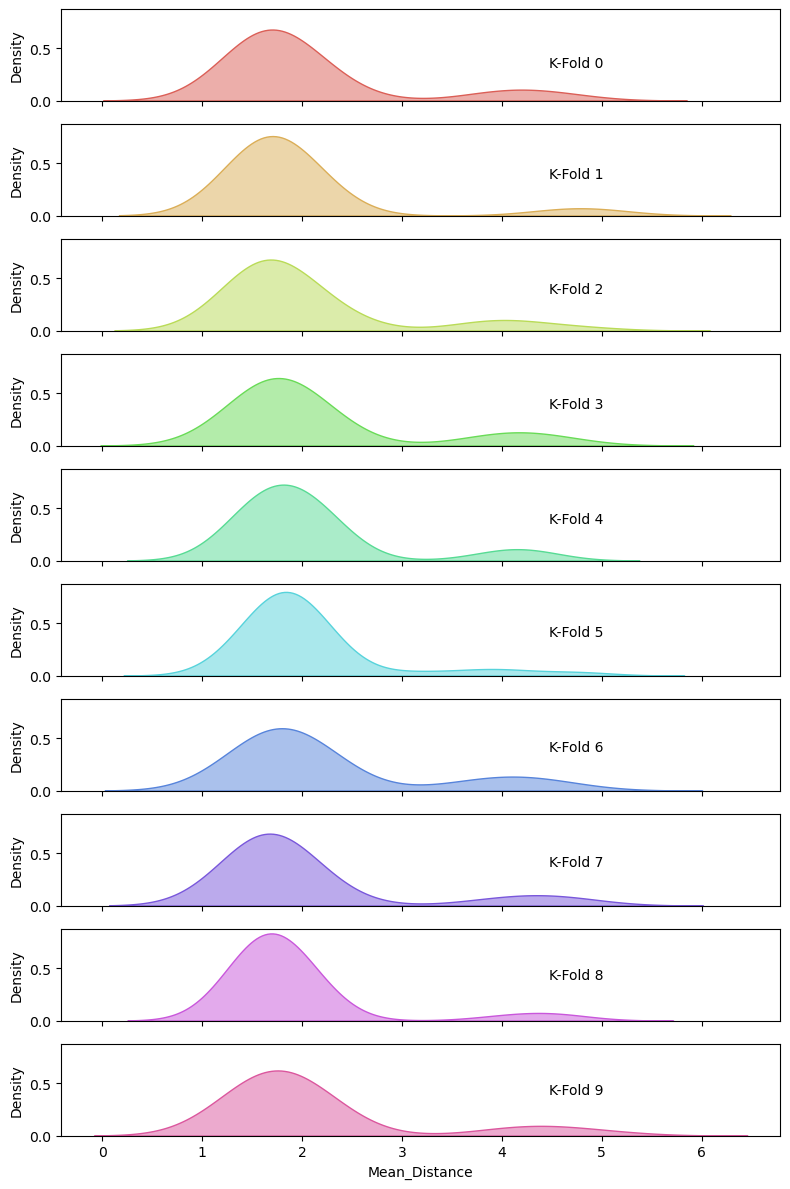

In [177]:
# Determine the number of unique labels for subplot layout
num_labels = tip_to_fold['K-Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
#fig.suptitle('Density Plot of Distances by Label')  # Overall figure title

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tip_to_fold['K-Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tip_to_fold['Mean_Distance'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tip_to_fold[tip_to_fold['K-Fold'] == label]['Mean_Distance']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'K-Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

In [178]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, get_simp_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [179]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = './vpod_1.1_data_subsets_2024-05-02'
# path to sequences of interest
seqFileName = f'{path}/wt_aligned_VPOD_1.1_het.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/wt_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.50

#Whether or not you want to drop the reference sequence from the training data- Usually 'Bovine' or 'Squid'
drop_ref = False

# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('/')[2]
#print(seqFile)
seqFile = seqFile.split('.')[0]
#print(seqFile)
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
# importing sequences data
print('reading fasta file')

tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)

shutil.copy2(f'{seqFileName}',report_dir)
write_fasta(dat = tr, fasta_file = f'{seqFile}_gap_dropped.fasta' , report_dir = report_dir)

try:
    reference_seq = tr.loc['Bovine'].copy()
    ref_seq_name = 'bovine'
    if drop_ref == True:
        meta_data = meta_data.drop('Bovine')
    #print(bovine)
except:
    reference_seq = tr.loc['Squid'].copy()
    ref_seq_name = 'squid'
    #print(squid)
reference_seq.to_csv(path_or_buf= f'{report_dir}/ref_sequence.csv',index = True,mode="w")

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
tr.shape

direcory preparation
reading meta-data
reading fasta file
wt_aligned_VPOD_1_gap_dropped.fasta was saved successfully


(362, 355)

In [180]:
tr.head(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p346,p347,p348,p349,p350,p351,p352,p353,p354,Lambda_Max
Bovine,M,NaN,N,G,T,E,G,P,N,F,...,NaN,NaN,NaN,S,Q,V,A,P,A,500.0
S1,M,NaN,N,G,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,502.0
S2,NaN,NaN,NaN,NaN,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,502.0
S3,NaN,NaN,NaN,NaN,T,E,G,P,D,F,...,S,A,NaN,S,S,V,S,P,A,481.0
S4,NaN,NaN,NaN,NaN,T,E,G,P,F,F,...,S,A,NaN,S,S,V,S,P,A,494.0
S5,NaN,NaN,NaN,NaN,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,494.0
S6,M,NaN,N,G,T,E,G,P,F,F,...,S,A,NaN,S,S,V,S,P,A,491.0
S7,NaN,NaN,NaN,NaN,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,486.0
S8,NaN,NaN,NaN,NaN,T,E,G,P,D,F,...,S,A,NaN,S,S,V,S,P,A,490.0
S9,NaN,NaN,NaN,NaN,T,E,G,P,D,F,...,S,A,NaN,S,S,V,S,P,A,490.0


In [181]:
tr = tr.reindex(tip_to_fold.index)

In [182]:
tr.head(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p346,p347,p348,p349,p350,p351,p352,p353,p354,Lambda_Max
Tip_Names,,,,,,,,,,,,,,,,,,,,,
Bovine,M,NaN,N,G,T,E,G,P,N,F,...,NaN,NaN,NaN,S,Q,V,A,P,A,500.0
S1,M,NaN,N,G,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,502.0
S2,NaN,NaN,NaN,NaN,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,502.0
S4,NaN,NaN,NaN,NaN,T,E,G,P,F,F,...,S,A,NaN,S,S,V,S,P,A,494.0
S3,NaN,NaN,NaN,NaN,T,E,G,P,D,F,...,S,A,NaN,S,S,V,S,P,A,481.0
S8,NaN,NaN,NaN,NaN,T,E,G,P,D,F,...,S,A,NaN,S,S,V,S,P,A,490.0
S9,NaN,NaN,NaN,NaN,T,E,G,P,D,F,...,S,A,NaN,S,S,V,S,P,A,490.0
S5,NaN,NaN,NaN,NaN,T,E,G,P,Y,F,...,S,A,NaN,S,S,V,S,P,A,494.0
S6,M,NaN,N,G,T,E,G,P,F,F,...,S,A,NaN,S,S,V,S,P,A,491.0


In [183]:
tr['Fold'] = tip_to_fold['Fold']

In [184]:
tr['K-Fold'] = tip_to_fold['K-Fold']

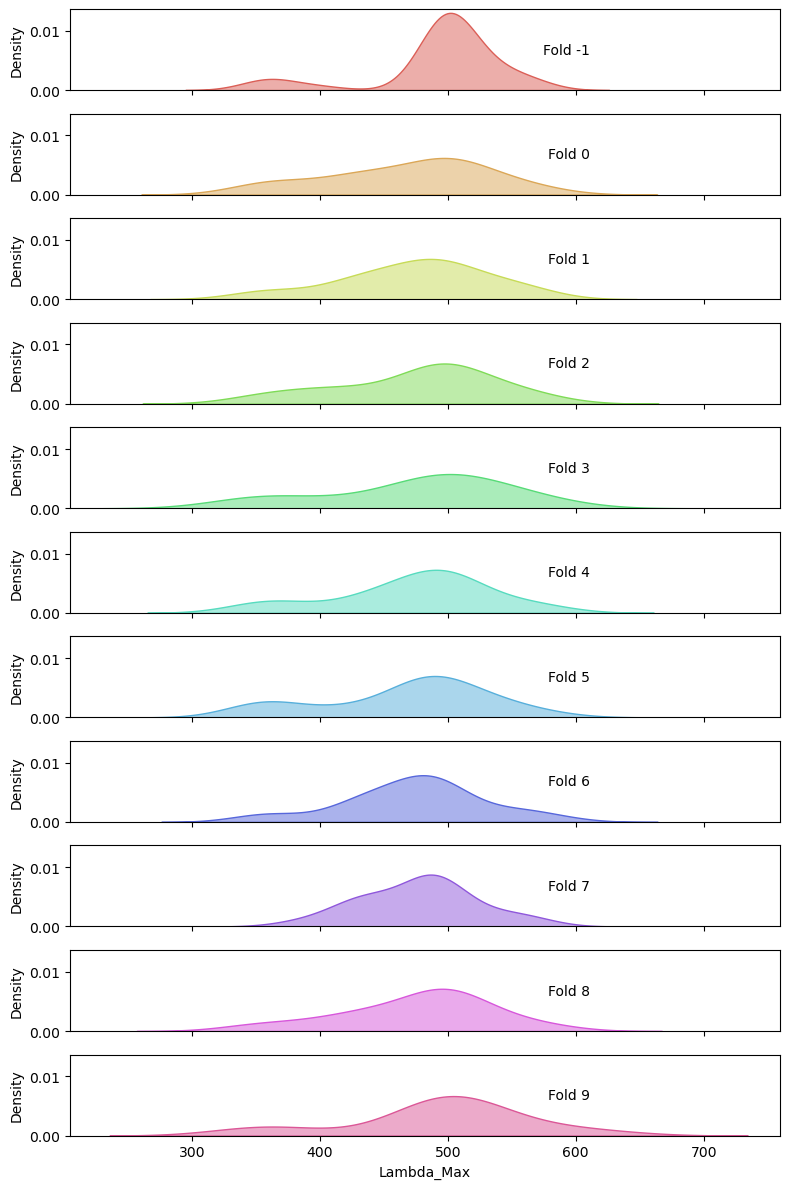

In [185]:
# Determine the number of unique labels for subplot layout
num_labels = tr['Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
#fig.suptitle('Density Plot of Distances by Label')  # Overall figure title

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tr['Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tr['Lambda_Max'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tr[tr['Fold'] == label]['Lambda_Max']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

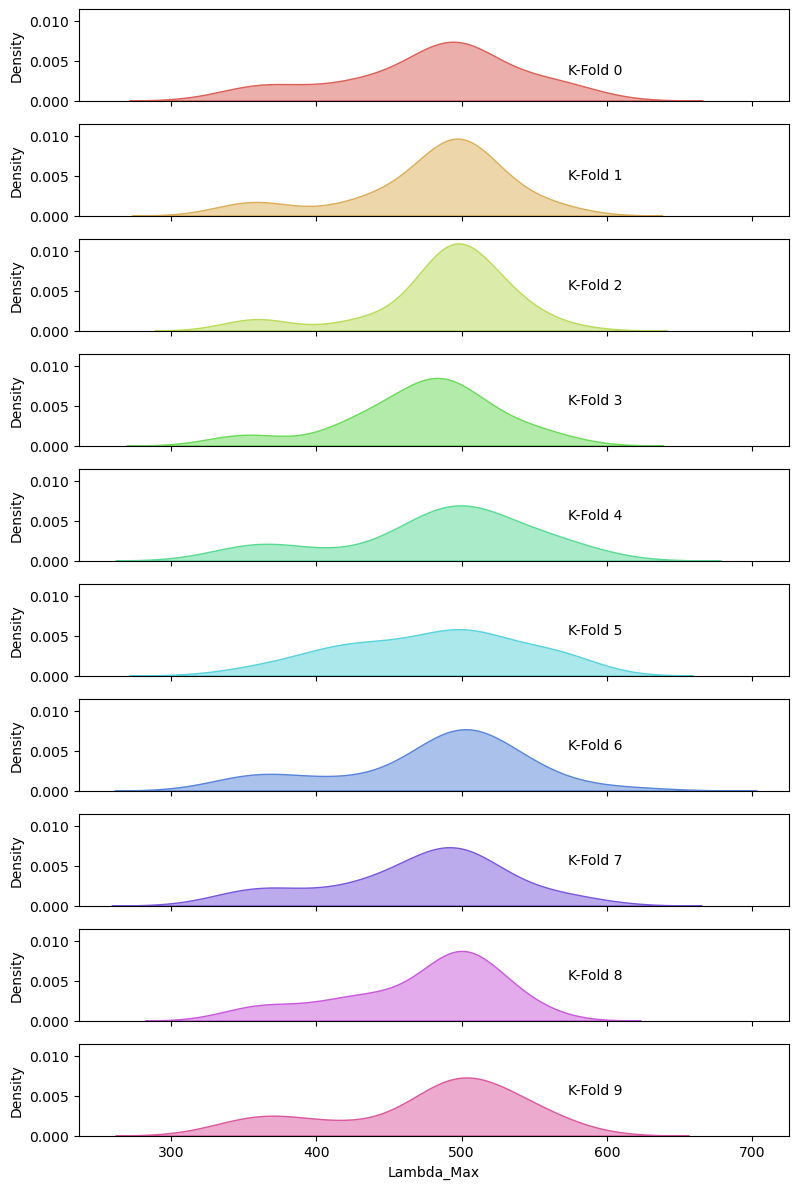

In [186]:
# Determine the number of unique labels for subplot layout
num_labels = tr['K-Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
#fig.suptitle('Density Plot of Distances by Label')  # Overall figure title

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tr['K-Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tr['Lambda_Max'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tr[tr['K-Fold'] == label]['Lambda_Max']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'K-Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()